$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}\;}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}\;}$

# Linear Ridge Regression

Remember when we were discussing the complexity of models?  The simplest model was a constant.  A simple way to predict rainfall is to ignore all measurements and just predict the average rainfall.  If a linear model of measurements may do no better.  The degree to which it does do better can be expressed in the relative sum of squared errors (RSE) or

$$RSE = \frac{\sum_{i=1}^N (\tv_i - \xv_i^T \wv)^2}{\sum_{i=1}^N (\tv_i - \bar{\Tv})^2}$$

If RSE is 1, then your linear model is no better than using the mean.  The closer RSE is to 0, the better your linear model is.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!curl -O http://mlr.cs.umass.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data
!curl -O http://mlr.cs.umass.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30286  100 30286    0     0  85073      0 --:--:-- --:--:-- --:--:-- 84834
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1660  100  1660    0     0  10641      0 --:--:-- --:--:-- --:--:-- 10641


In [3]:
def makeMPGData(filename='auto-mpg.data'):
    def missingIsNan(s):
        return np.nan if s == b'?' else float(s)
    data = np.loadtxt(filename, usecols=range(8), converters={3: missingIsNan})
    print("Read",data.shape[0],"rows and",data.shape[1],"columns from",filename)
    goodRowsMask = np.isnan(data).sum(axis=1) == 0
    data = data[goodRowsMask,:]
    print("After removing rows containing question marks, data has",data.shape[0],"rows and",data.shape[1],"columns.")
    X = data[:,1:]
    T = data[:,0:1]
    Xnames =  ['bias', 'cylinders','displacement','horsepower','weight','acceleration','year','origin']
    Tname = 'mpg'
    return X,T,Xnames,Tname

In [4]:
X,T,Xnames,Tname = makeMPGData()

Read 398 rows and 8 columns from auto-mpg.data
After removing rows containing question marks, data has 392 rows and 8 columns.


In [7]:
means = X.mean(0)
stds = X.std(0)
nRows = X.shape[0]
Xs1 = np.insert((X-means)/stds, 0, 1, axis=1) # insert column of ones in new 0th column
# Xs1 = np.hstack(( np.ones((nRows,1)), (X-means)/stds ))
w = np.linalg.lstsq(Xs1.T @ Xs1, Xs1.T @ T)[0]
w

/home/pkt/VENV/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


array([[23.44591837],
       [-0.84051891],
       [ 2.07930256],
       [-0.65163644],
       [-5.49205044],
       [ 0.22201407],
       [ 2.76211888],
       [ 1.14731588]])

In [8]:
# predict = Xs1.dot(w)
predict = Xs1 @ w
RSE = np.sum((T-predict)**2) / np.sum((T - T.mean(0))**2)
RSE

0.17852192351894022

So, our linear model seems to be quite a bit better than using just the mean mpg.  If our linear model is worse than using the mean, this value would be greater than 1.

Well, maybe our model would do better if it was a little closer to just the mean, or, equivalently, just using the bias weight.  This is the question that drives the derivation of "ridge regression".  Let's add a term to our sum of squared error objective function that is the sum of all weight magnitudes except the bias weight.  Then, we not only minimize the sum of squared errors, we also minimize the sum of the weight magnitudes:

$$ \sum_{i=1}^N (\tv_i - \xv_i^T \wv)^2 + \lambda \sum_{i=2}^N w_i^2$$

Notice that $\lambda$ in there.  With $\lambda=0$ we have our usual linear regression objective function. With $\lambda>0$, we are adding in a penalty for the weight magnitudes.

How does this change our solution for the best $\wv$?  You work it out.  You should get

$$ \wv = (X^T X + \lambda I)^{-1} X^T T $$

except instead of using 

$$
    \lambda I =
     \begin{bmatrix}
     \lambda & 0 & \dotsc & 0\\
       0 & \lambda & \dotsc & 0\\
       \vdots \\
       0 & 0 & \dotsc & \lambda
    \end{bmatrix}
$$

we want

$$
     \begin{bmatrix}
      0 & 0 & \dotsc & 0\\
       0 & \lambda & \dotsc & 0\\
       \vdots \\
       0 & 0 & \dotsc & \lambda
    \end{bmatrix}
$$

so we don't penalize the bias weight, the weight multiplying the constant 1 input component.


Now, what value should $\lambda$ be?  Must determine empirically, by calculating the sum of squared error on test data.

Actually, we should not find the best value of $\lambda$ by comparing error on the test data. This will give us a too optimistic prediction of error on novel data, because the test data was used to pick the best $\lambda$.  We really must hold out another partition of data from the training set for this. This third partition is often called the model validation set.  So, we partition our data into disjoint training, validation, and testing subsets, and

* For each value of $\lambda$
  * Solve for $\wv$ using the training set
  * Use $\wv$ to predict the output for the validation set and calculate the squared error.
  * Use $\wv$ to predict the output for the testing set and calculate the squared error.
  * Pick value of $\lambda$ that produced the lowest validation set error, and report the testing set error obtained using that value of $\lambda$.

Let's do it!

In [18]:
lamb = 0.1
D = Xs1.shape[1]
lambdaDiag = np.eye(D) * lamb
lambdaDiag[0,0] = 0
lambdaDiag


array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1]])

In [19]:
def makeLambda(D,lamb=0):
    lambdaDiag = np.eye(D) * lamb
    lambdaDiag[0,0] = 0
    return lambdaDiag
makeLambda(3,0.2)

array([[0. , 0. , 0. ],
       [0. , 0.2, 0. ],
       [0. , 0. , 0.2]])

In [20]:
w = np.linalg.lstsq(Xs1.T @ Xs1 + lambdaDiag, Xs1.T @ T)[0]
w

/home/pkt/VENV/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


array([[23.44591837],
       [-0.83453746],
       [ 2.05581595],
       [-0.6544685 ],
       [-5.474439  ],
       [ 0.21836873],
       [ 2.76033842],
       [ 1.14610564]])

In [21]:
%precision 2

'%.2f'

In [22]:
D = Xs1.shape[1]
wLambda10 = np.linalg.lstsq(Xs1.T @ Xs1 + makeLambda(D,10.0), Xs1.T @ T)[0]
wLambda0 = np.linalg.lstsq(Xs1.T @ Xs1 + makeLambda(D,0), Xs1.T @ T)[0]
np.hstack((wLambda10,wLambda0))

/home/pkt/VENV/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/home/pkt/VENV/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[ 2.34e+01,  2.34e+01],
       [-6.06e-01, -8.41e-01],
       [ 7.05e-01,  2.08e+00],
       [-8.74e-01, -6.52e-01],
       [-4.30e+00, -5.49e+00],
       [-7.00e-03,  2.22e-01],
       [ 2.62e+00,  2.76e+00],
       [ 1.08e+00,  1.15e+00]])

/home/pkt/VENV/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


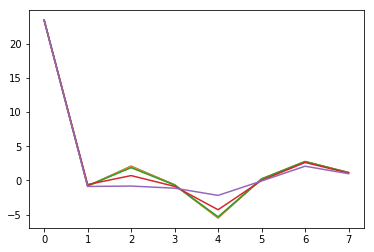

In [24]:
lambdas = [0,0.1,1,10,100]
for lamb in lambdas:
    w = np.linalg.lstsq(Xs1.T @ Xs1 + makeLambda(D,lamb), Xs1.T @ T)[0]
    plt.plot(w)

/home/pkt/VENV/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


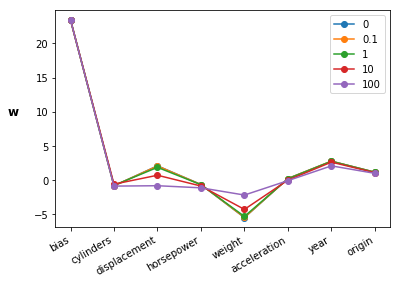

In [25]:
lambdas = [0,0.1,1,10,100]
for lamb in lambdas:
    w = np.linalg.lstsq(Xs1.T @ Xs1 + makeLambda(D,lamb), Xs1.T @ T)[0]
    plt.plot(w, '-o')
plt.xticks(range(8), Xnames, rotation=30, horizontalalignment='right')
plt.ylabel('$\mathbf{w}$', fontsize='large', rotation='horizontal', labelpad=20)
plt.legend(lambdas);

Since we are not modifying the bias weight, let's take it out of the plot.

/home/pkt/VENV/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


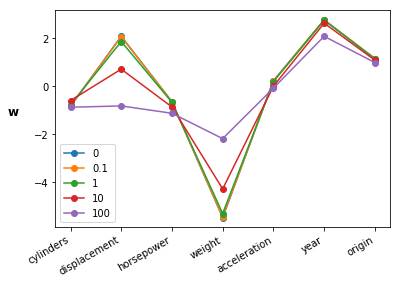

In [26]:
lambdas = [0,0.1,1,10,100]
for lamb in lambdas:
    w = np.linalg.lstsq(Xs1.T @ Xs1 + makeLambda(D,lamb), Xs1.T @ T)[0]
    plt.plot(w[1:], '-o')
plt.xticks(range(7), Xnames[1:], rotation=30, horizontalalignment='right')
plt.ylabel('$\mathbf{w}$', fontsize='large', rotation='horizontal', labelpad=20)
plt.legend(lambdas);

/home/pkt/VENV/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


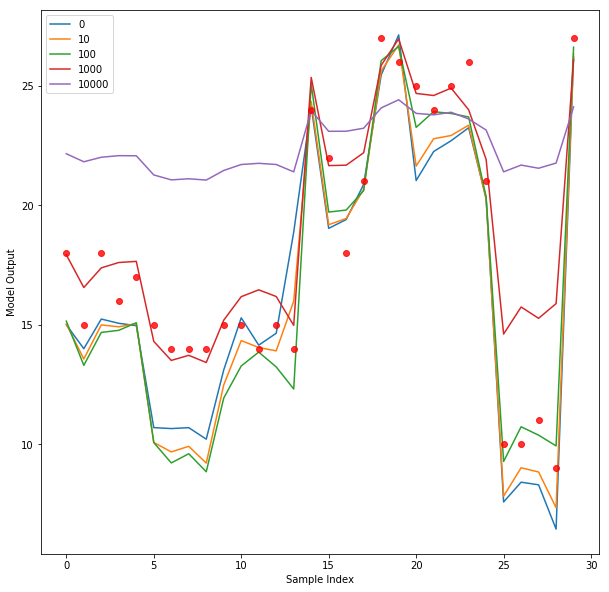

In [27]:
plt.figure(figsize=(10, 10))
lambdas = [0, 10, 100, 1000, 10000]
for lamb in lambdas:
    w = np.linalg.lstsq(Xs1.T @ Xs1 + makeLambda(D,lamb), Xs1.T @ T)[0]
    plt.plot(Xs1[:30] @ w)
plt.plot(T[:30],'ro',lw=5,alpha=0.8)
plt.ylabel('Model Output')
plt.xlabel('Sample Index')
plt.legend(lambdas,loc='best')

Which $\lambda$ value is best?  Careful.  What is the best value of $\lambda$ if just comparing error on training data?

Now, careful again!  Can't report expected error from testing data that is also used to pick best value of $\lambda$.  Error is likely to be better than what you will get on new data that was not used to train the model and also was not used to pick value of $\lambda$.

Need a way to partition our data into training, validation and testing subsets.  Let's write a function that makes these partitions randomly, given the data matrix and the fractions to be used in the three partitions.

In [28]:
def partition(X,T,trainFraction=0.8, validateFraction=0.1, testFraction=0.1):
    '''Usage: Xtrain,Ttrain,Xval,Tval,Xtest,Ttext = partition(X,T,0.8,0.2,0.2)'''
    if trainFraction + validateFraction + testFraction != 1:
        raise ValueError("Train, validate and test fractions must sum to 1. Given values sum to " + str(trainFraction+validateFraction+testFraction))
    n = X.shape[0]
    nTrain = round(trainFraction * n)
    nValidate = round(validateFraction * n)
    nTest = round(testFraction * n)
    if nTrain + nValidate + nTest != n:
        nTest = n - nTrain - nValidate
    # Random order of data matrix row indices
    rowIndices = np.arange(X.shape[0])
    np.random.shuffle(rowIndices)
    # Build X and T matrices by selecting corresponding rows for each partition
    Xtrain = X[rowIndices[:nTrain],:]
    Ttrain = T[rowIndices[:nTrain],:]
    Xvalidate = X[rowIndices[nTrain:nTrain+nValidate],:]
    Tvalidate = T[rowIndices[nTrain:nTrain+nValidate],:]
    Xtest = X[rowIndices[nTrain+nValidate:nTrain+nValidate+nTest],:]
    Ttest = T[rowIndices[nTrain+nValidate:nTrain+nValidate+nTest],:]
    return Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest

In [29]:
X = np.arange(20).reshape((10,2))
X

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19]])

In [30]:
T = np.arange(10).reshape((-1,1))
T

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [31]:
X = np.arange(20).reshape((10,2)) + np.random.uniform(0,1,(10,2))
T = np.arange(10).reshape((-1,1))
Xtrain,Ttrain,Xval,Tval,Xtest,Ttest = partition(X,T,0.6,0.2,0.2)

In [32]:
print("Xtrain:")
print(Xtrain)
print(" Ttrain:")
print(Ttrain)
print("\n Xval:")
print(Xval)
print(" Tval:")
print(Tval)
print("\n Xtest:")
print(Xtest)
print(" Ttest:")
print(Ttest)

Xtrain:
[[ 2.35  3.52]
 [16.27 17.61]
 [12.83 13.9 ]
 [ 8.33  9.41]
 [10.7  11.17]
 [ 4.75  5.11]]
 Ttrain:
[[1]
 [8]
 [6]
 [4]
 [5]
 [2]]

 Xval:
[[ 6.36  7.21]
 [18.97 19.23]]
 Tval:
[[3]
 [9]]

 Xtest:
[[14.29 15.49]
 [ 0.89  1.26]]
 Ttest:
[[7]
 [0]]


Now we can train our model using several values of $\lambda$ on Xtrain,Train and calculate the model error on Xval,Tval. Then pick best value of $\lambda$ based on error on Xval,Tval. Finally, calculate error of model using best $\lambda$ on Xtest,Ttest as our estimate of error on new data.

However, these errors will be affected by the random partitioning of the data.  Repeating with new partitions may result in a different $\lambda$ being best.  We should repeat the above procedure many times and average over the results.  How many repetitions do we need?

Another approach, commonly followed in machine learning, is to first partition the data into $k$ subsets, called "folds".  Pick one fold to be the test partition, another fold to be the validate partition, and collect the remaining folds to be the train partition.  We can do this $k\,(k-1)$ ways. (Why?)  So, with $k=5$ we get 20 repetitions performed in a way that most distributes samples among the partitions.

First, a little note on the `yield` statement in python. The `yield` statement is like `return` except that execution pauses at this point in the function, after returning the values.  When the function is called again, it continues from that paused point. 

In [33]:
def count(n):
    for a in range(n):
        yield a

In [34]:
count(4)

<generator object count at 0x7fa717195830>

In [35]:
list(count(4))

[0, 1, 2, 3]

In [36]:
for i in count(5):
    print(i)

0
1
2
3
4


In [37]:
 def partitionKFolds(X,T,nFolds,shuffle=False,nPartitions=3):
    '''Usage: for Xtrain,Ttrain,Xval,Tval,Xtest,Ttext in partitionKFolds(X,T,5,shuffle=True,nPartitions=3):
            for Xtrain,Ttrain,Xtest,Ttext in partitionKFolds(X,T,5,shuffle=True,nPartitions=2):'''
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    for testFold in range(nFolds):
        if nPartitions == 3:
            # Repeat with validateFold taking each single fold, except for the testFold
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                # Return partition matrices, then suspend until called again.
                yield Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest,testFold
        else:
            # trainFolds are all remaining folds, after selecting test and validate folds
            trainFolds = np.setdiff1d(range(nFolds), [testFold])
            # Construct Xtrain and Ttrain by collecting rows for all trainFolds
            rows = []
            for tf in trainFolds:
                a,b = startsStops[tf]                
                rows += rowIndices[a:b].tolist()
            Xtrain = X[rows,:]
            Ttrain = T[rows,:]
            # Construct Xtest and Ttest
            a,b = startsStops[testFold]
            rows = rowIndices[a:b]
            Xtest = X[rows,:]
            Ttest = T[rows,:]
            # Return partition matrices, then suspend until called again.
            yield Xtrain,Ttrain,Xtest,Ttest,testFold

In [38]:
X = np.arange(20).reshape((10,2))
T = np.arange(10).reshape((-1,1)) + np.random.uniform(-1, 1, (10,1))
k = 0
for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,testFold in partitionKFolds(X,T,5):
    k += 1
    print("Fold",k)
    print(" Xtrain:")
    print(Xtrain)
    print(" Ttrain:")
    print(Ttrain)
    print("\n Xval:")
    print(Xval)
    print(" Tval:")
    print(Tval)
    print("\n Xtest:")
    print(Xtest)
    print(" Ttest:")
    print(Ttest)

Fold 1
 Xtrain:
[[ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
 Ttrain:
[[3.03]
 [5.97]
 [6.97]
 [7.31]
 [8.48]
 [9.2 ]]

 Xval:
[[4 5]
 [6 7]]
 Tval:
[[2.66]
 [3.62]]

 Xtest:
[[0 1]
 [2 3]]
 Ttest:
[[-0.43]
 [ 1.91]]
Fold 2
 Xtrain:
[[ 4  5]
 [ 6  7]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
 Ttrain:
[[2.66]
 [3.62]
 [6.97]
 [7.31]
 [8.48]
 [9.2 ]]

 Xval:
[[ 8  9]
 [10 11]]
 Tval:
[[3.03]
 [5.97]]

 Xtest:
[[0 1]
 [2 3]]
 Ttest:
[[-0.43]
 [ 1.91]]
Fold 3
 Xtrain:
[[ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [16 17]
 [18 19]]
 Ttrain:
[[2.66]
 [3.62]
 [3.03]
 [5.97]
 [8.48]
 [9.2 ]]

 Xval:
[[12 13]
 [14 15]]
 Tval:
[[6.97]
 [7.31]]

 Xtest:
[[0 1]
 [2 3]]
 Ttest:
[[-0.43]
 [ 1.91]]
Fold 4
 Xtrain:
[[ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]]
 Ttrain:
[[2.66]
 [3.62]
 [3.03]
 [5.97]
 [6.97]
 [7.31]]

 Xval:
[[16 17]
 [18 19]]
 Tval:
[[8.48]
 [9.2 ]]

 Xtest:
[[0 1]
 [2 3]]
 Ttest:
[[-0.43]
 [ 1.91]]
Fold 5
 Xtrain:
[[ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
 Ttrain:


Typical use of these partitions is shown below.  It is most handy to just collect all results in a matrix and calculate averages afterwards, rather than accumulating each result and dividing by the number of repetitions at the end.

In [39]:
def train(X, T, lamb):
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.insert( (X - means)/stds, 0, 1, axis=1)
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( Xs1.T @ Xs1 + lambDiag, Xs1.T @ T)[0]
    return {'w': w, 'means': means, 'stds': stds}

def use(model, X):
    Xs1 = np.insert((X-model['means'])/model['stds'], 0, 1, axis=1)
    return Xs1 @ model['w']

def rmse(A,B):
    return np.sqrt(np.mean( (A-B)**2 ))

def evaluate(model, X, T):
    return rmse(use(model, X), T)

In [41]:
lambdas = np.linspace(0, 5, 20)
lambdas

array([0.  , 0.26, 0.53, 0.79, 1.05, 1.32, 1.58, 1.84, 2.11, 2.37, 2.63,
       2.89, 3.16, 3.42, 3.68, 3.95, 4.21, 4.47, 4.74, 5.  ])

In [44]:
lambdas = np.linspace(0, 5, 20)
results = []
for Xtrain, Ttrain, Xval, Tval, Xtest, Ttest,_ in partitionKFolds(X, T, 5):
    for lamb in lambdas:
        model = train(Xtrain, Ttrain, lamb)
        predict = use(model, Xval)
        results.append([lamb,
                        evaluate(model, Xtrain, Ttrain),
                        evaluate(model, Xval, Tval),
                        evaluate(model, Xtest, Ttest)])
results = np.array(results)
# print(results)
avgresults = []
for lam in lambdas:
#     print(lam)
#     print(results[results[:,0]==lam,1:])
    avgresults.append( [lam] + np.mean(results[results[:,0]==lam,1:],axis=0).tolist())
avgresults = np.array(avgresults)
# print(avgresults)

/home/pkt/VENV/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


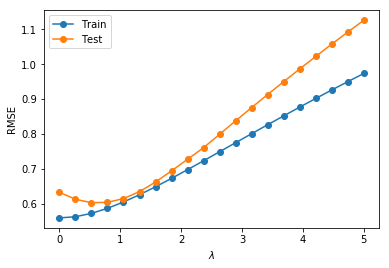

In [45]:
plt.plot(avgresults[:,0],avgresults[:,[1, 3]],'o-')
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.legend(('Train', 'Test'),loc='best');

Here is yet another python implementation that includes many of the common steps used when training and evaluating models.  We will use this version for many of our experiments.

In [46]:
def trainValidateTestKFolds(trainf, evaluatef, X, T, parameterSets, nFolds=5,
                            shuffle=False, verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    isNewBetterThanOld = lambda new,old: new < old
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("trainValidateTestKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds, nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts, stops))
        
    # Repeat with testFold taking each single fold, one at a time
    results = []
    for testFold in range(nFolds):
        # Leaving the testFold out, for each validate fold, train on remaining
        # folds and evaluate on validate fold. Collect theseRepeat with validate
        # Construct Xtest and Ttest
        a,b = startsStops[testFold]
        rows = rowIndices[a:b]
        Xtest = X[rows, :]
        Ttest = T[rows, :]

        bestParms = None
        for parms in parameterSets:
            # trainEvaluationSum = 0
            validateEvaluationSum = 0
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # Construct Xtrain and Ttrain
                trainFolds = np.setdiff1d(range(nFolds), [testFold, validateFold])
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows, :]
                Ttrain = T[rows, :]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows, :]
                Tvalidate = T[rows, :]

                model = trainf(Xtrain, Ttrain, parms)
                # trainEvaluationSum += evaluatef(model,Xtrain,Train)
                validateEvaluationSum += evaluatef(model, Xvalidate, Tvalidate)
            validateEvaluation = validateEvaluationSum / (nFolds-1)
            if verbose:
                if hasattr(model, 'bestIteration') and model.bestIteration is not None:
                    print('{} Val {:.3f} Best Iter {:d}'.format(parms, validateEvaluation, model.bestIteration))
                else:
                    print('{} Val {:.3f}'.format(parms, validateEvaluation))

            if bestParms is None or isNewBetterThanOld(validateEvaluation, bestValidationEvaluation): 
                bestParms = parms
                bestValidationEvaluation = validateEvaluation
                if verbose:
                    print('New best')
                # trainEvaluation = trainEvaluationSum / (nFolds-1)

        newXtrain = np.vstack((Xtrain, Xvalidate))
        newTtrain = np.vstack((Ttrain, Tvalidate))

        model = trainf(newXtrain, newTtrain, bestParms)
        trainEvaluation = evaluatef(model, newXtrain, newTtrain)
        testEvaluation = evaluatef(model, Xtest, Ttest)

        # resultThisTestFold = [bestParms, trainEvaluation,
        #                       bestValidationEvaluation, testEvaluation]
        resultThisTestFold = [nFolds, testFold+1, bestParms, trainEvaluation, bestValidationEvaluation, testEvaluation]
        results.append(resultThisTestFold)
        if verbose:
            print(resultThisTestFold)
        print('{}/{}'.format(testFold+1, nFolds), end=' ', flush=True)
    return np.array(results) # pandas.DataFrame(results, columns=('nFolds','testFold','parms','trainAcc','testAcc'))

In [47]:
lambdas = np.linspace(0, 5, 20)
results = trainValidateTestKFolds(train, evaluate, X, T, lambdas, nFolds=5, 
                                  shuffle=True, verbose=False)

1/5 2/5 3/5 

/home/pkt/VENV/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


4/5 5/5 

In [48]:
results

array([[5.  , 1.  , 0.  , 0.62, 0.72, 0.59],
       [5.  , 2.  , 0.26, 0.59, 0.69, 0.77],
       [5.  , 3.  , 0.  , 0.63, 0.79, 0.49],
       [5.  , 4.  , 0.  , 0.61, 0.76, 0.6 ],
       [5.  , 5.  , 0.26, 0.45, 0.58, 1.05]])

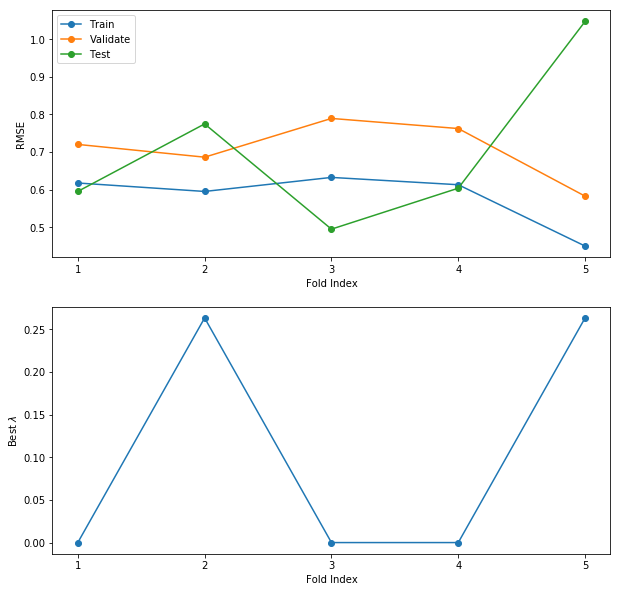

In [49]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(results[:,1], results[:,3:6],'o-')
plt.xticks(range(1,6))  # without this, we see 1.5, 2.5, etc.
plt.xlabel('Fold Index')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best')

plt.subplot(2, 1, 2)
plt.plot(results[:,1], results[:,2], '-o')
plt.xticks(range(1,6))
plt.xlabel('Fold Index')
plt.ylabel('Best $\lambda$');

In [20]:
import numpy as np
np.random.choice(range(10),5,replace=False)


array([0, 2, 6, 5, 7])

In [30]:
a=np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3]])
a[[0,1]]

array([[1, 1, 1, 1],
       [2, 2, 2, 2]])

In [40]:
import random
a=[1,2,3,4,5,6,7,8,9]
random.sample(range(0, len(a)), 2)

[2, 3]